### Pyspark initialization

In [90]:
from pyspark.sql.functions import *

#import spark
from pyspark.sql import SparkSession
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ass2 BNPL group 28")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

### Read and filter data

In [91]:
## read main and external dataset
curated_csv = spark.read.options(header = True).csv('../../data/curated/full_data.csv')
sa2_pos_2021 = spark.read.options(header = True).csv('../../data/tables/sa2_pos_2021.csv')
population = spark.read.options(header = True).csv('../../data/tables/2021Census_G01_AUST_SA2.csv')
income = spark.read.options(header = True).csv('../../data/tables/2021Census_G02_AUST_SA2.csv')

In [92]:
## Drop unhelpful columns in both external dataset
population = population.select(col('SA2_CODE_2021'), col('Tot_P_P'))
income = income.select(col('SA2_CODE_2021'), col('Median_tot_prsnl_inc_weekly'))

## change data type
population = population.withColumn("Tot_P_P",population.Tot_P_P.cast('int'))
income = income.withColumn('Median_tot_prsnl_inc_weekly', income.Median_tot_prsnl_inc_weekly.cast('float'))

In [93]:
population.limit(4)

SA2_CODE_2021,Tot_P_P
101021007,4343
101021008,8517
101021009,11342
101021010,5085


### Joining external data
In this step we join the external dataset to our curated dataset filtered and cleaned previously

In [94]:
## merge SA2 population (sum of different sa2 areas) with postcode
pos_population = sa2_pos_2021.join(population, sa2_pos_2021.SA2_CODE_2021 == population.SA2_CODE_2021, "inner").drop(population.SA2_CODE_2021)
pos_population = pos_population.groupBy('POA_CODE_2021').sum('Tot_P_P')
pos_population = pos_population.withColumnRenamed('sum(Tot_P_P)', 'total_population')

pos_population.show(3)

+-------------+----------------+
|POA_CODE_2021|total_population|
+-------------+----------------+
|         2294|            9202|
|         6613|            4471|
|         2162|           43228|
+-------------+----------------+
only showing top 3 rows



In [95]:
## merge SA2 income (average personal income in different sa2 areas) with postcode
pos_income= sa2_pos_2021.join(income, sa2_pos_2021.SA2_CODE_2021 == income.SA2_CODE_2021, "inner").drop(income.SA2_CODE_2021)
pos_income = pos_income.groupBy('POA_CODE_2021').avg('Median_tot_prsnl_inc_weekly')
pos_income = pos_income.withColumn("avg_personal_income_weekly", round(pos_income["avg(Median_tot_prsnl_inc_weekly)"], 1))
pos_income = pos_income.drop('avg(Median_tot_prsnl_inc_weekly)')
pos_income.show(3)

+-------------+--------------------------+
|POA_CODE_2021|avg_personal_income_weekly|
+-------------+--------------------------+
|         2294|                    1029.0|
|         6613|                     892.0|
|         2162|                     494.5|
+-------------+--------------------------+
only showing top 3 rows



In [96]:
## join both income and population with postcode
pos_info = pos_population.join(pos_income, pos_population.POA_CODE_2021 == pos_income.POA_CODE_2021, 'inner').drop(pos_income.POA_CODE_2021)

pos_info = pos_info.select('POA_CODE_2021', 'total_population', 'avg_personal_income_weekly')
pos_info.show(3)

+-------------+----------------+--------------------------+
|POA_CODE_2021|total_population|avg_personal_income_weekly|
+-------------+----------------+--------------------------+
|         2294|            9202|                    1029.0|
|         6613|            4471|                     892.0|
|         2162|           43228|                     494.5|
+-------------+----------------+--------------------------+
only showing top 3 rows



In [97]:
## join pos_info with original dataset
curated_csv_new = curated_csv.join(pos_info, curated_csv.postcode == pos_info.POA_CODE_2021, "leftouter").drop(pos_info.POA_CODE_2021)
print(curated_csv_new.count())
curated_csv_new.limit(3)

14195505


user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,address,state,postcode,gender,field,revenue_level,take_rate,total_population,avg_personal_income_weekly
5574,58476363584,66.29,401ee716-6a4d-400...,2021-08-20,1719,Mauris Blandit Fo...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"watch, clock, and...",a,6.49,null,null
5574,46804135891,0.49,1ae8d9be-ee74-479...,2022-09-08,1719,Suspendisse Dui C...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"opticians, optica...",c,2.93,null,null
5574,98166254020,1728.46,72934e47-3c41-476...,2021-08-20,1719,Magna Sed Industries,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,art dealers and g...,a,5.96,null,null


### Data visualization and outlier checking
In this step we fill the null values with mean and try to visualize the distribution of each data column. We try to check whether there are outliers that lie too far away from the median.

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import builtins
round = getattr(builtins, "round")

In [99]:
# use mean to fill null value of income and population
curated_csv_df1 = curated_csv_new
income_mean = np.mean(income.select('Median_tot_prsnl_inc_weekly').collect())
population_mean = np.mean(population.select('Tot_P_P').collect())
curated_csv_df1 = curated_csv_df1.na.fill({'avg_personal_income_weekly':round(income_mean,1),'total_population':population_mean})
curated_csv_df1.limit(3)

user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,address,state,postcode,gender,field,revenue_level,take_rate,total_population,avg_personal_income_weekly
5574,58476363584,66.29,401ee716-6a4d-400...,2021-08-20,1719,Mauris Blandit Fo...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"watch, clock, and...",a,6.49,10284,943.3
5574,46804135891,0.49,1ae8d9be-ee74-479...,2022-09-08,1719,Suspendisse Dui C...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"opticians, optica...",c,2.93,10284,943.3
5574,98166254020,1728.46,72934e47-3c41-476...,2021-08-20,1719,Magna Sed Industries,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,art dealers and g...,a,5.96,10284,943.3


### Distribution plots

<AxesSubplot:ylabel='Density'>

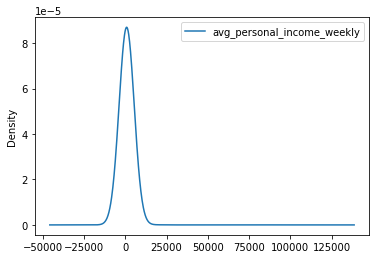

In [100]:
# draw a distribution plot
# check outliers
sample = curated_csv_df1.sample(0.5).select('avg_personal_income_weekly')
sample = sample.toPandas()
sample.plot.kde(bw_method=3)


<AxesSubplot:ylabel='Density'>

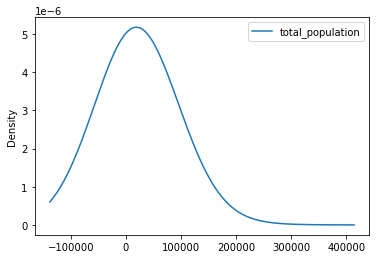

In [101]:
sample1 = curated_csv_df1.sample(0.5).select('total_population')
sample1 = sample1.toPandas()
sample1.plot.kde(bw_method=3)

In [102]:
# use median to fill null value of income and population
curated_csv_df2 = curated_csv_new
income_median = np.median(income.select('Median_tot_prsnl_inc_weekly').collect())
population_median = np.median(population.select('Tot_P_P').collect())
curated_csv_df2 = curated_csv_df2.na.fill({'avg_personal_income_weekly':round(income_median,1),'total_population':population_median})
curated_csv_df2.limit(3)

user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id,merchant_name,user_name,address,state,postcode,gender,field,revenue_level,take_rate,total_population,avg_personal_income_weekly
5574,58476363584,66.29,401ee716-6a4d-400...,2021-08-20,1719,Mauris Blandit Fo...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"watch, clock, and...",a,6.49,9656,798.0
5574,46804135891,0.49,1ae8d9be-ee74-479...,2022-09-08,1719,Suspendisse Dui C...,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,"opticians, optica...",c,2.93,9656,798.0
5574,98166254020,1728.46,72934e47-3c41-476...,2021-08-20,1719,Magna Sed Industries,Ashley Ellis,08935 Anderson Cr...,NSW,1001,Female,art dealers and g...,a,5.96,9656,798.0


<AxesSubplot:ylabel='Density'>

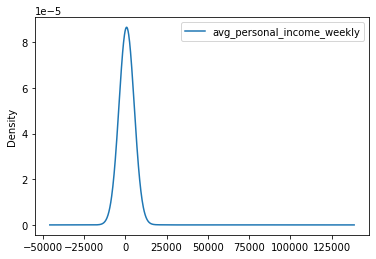

In [103]:
# draw a distribution plot
# check outliers
sample = curated_csv_df2.sample(0.5).select('avg_personal_income_weekly')
sample = sample.toPandas()
sample.plot.kde(bw_method=3)

<AxesSubplot:ylabel='Density'>

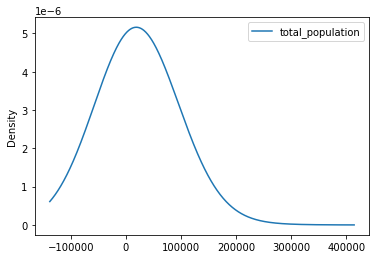

In [104]:
sample1 = curated_csv_df2.sample(0.5).select('total_population')
sample1 = sample1.toPandas()
sample1.plot.kde(bw_method=3)